# Advanced Mental Health Signal Detection in Arabic Tweets
## A Comprehensive Research Framework

### Research Objectives:
1. **Primary Goal**: Develop a robust multi-class classification system for detecting mental health signals in Arabic social media text
2. **Secondary Goals**:
   - Address class imbalance through advanced techniques
   - Leverage Arabic-specific NLP models and preprocessing
   - Implement interpretable ML approaches for clinical validity
   - Ensure ethical considerations in mental health AI applications

### Key Improvements:
- Arabic-specific text preprocessing and normalization
- Advanced feature engineering including psycholinguistic features
- State-of-the-art transformer models (AraBERT, CAMeLBERT)
- Proper handling of severe class imbalance
- Rigorous evaluation with clinical relevance metrics
- Model interpretability and error analysis
- Ethical considerations and bias detection

In [ ]:
# This cant be put in requirements.txt so it goes here. Restart the kernel after running this.
pip install emoji==1.7.0

## 1. Environment Setup and Dependencies

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# Enable tqdm for pandas
tqdm.pandas()

# Data handling
from collections import Counter, defaultdict
import json
import pickle
import re
import string
from datetime import datetime

# Fix emoji library compatibility issue
try:
    import emoji
    # For emoji 2.0+, use the new API
    if hasattr(emoji, 'EMOJI_DATA'):
        EMOJI_DATA = emoji.EMOJI_DATA
    else:
        # For newer versions, emoji functionality is handled differently
        EMOJI_DATA = None
except ImportError:
    EMOJI_DATA = None

# Arabic NLP libraries
import pyarabic.araby as araby
import camel_tools
from camel_tools.utils.normalize import normalize_alef_maksura_ar
from camel_tools.utils.normalize import normalize_alef_ar
from camel_tools.utils.normalize import normalize_teh_marbuta_ar
from camel_tools.tokenizers.word import simple_word_tokenize
from camel_tools.disambig.mle import MLEDisambiguator
from camel_tools.sentiment import SentimentAnalyzer
from arabert import ArabertPreprocessor
from farasa.segmenter import FarasaSegmenter
from farasa.pos import FarasaPOSTagger
from farasa.stemmer import FarasaStemmer

# Machine Learning
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, GridSearchCV, 
    RandomizedSearchCV, cross_val_score, cross_validate
)
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.manifold import TSNE
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    f1_score, precision_score, recall_score, roc_auc_score,
    precision_recall_curve, roc_curve, auc, matthews_corrcoef,
    cohen_kappa_score, make_scorer
)

# Advanced ML algorithms
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    ExtraTreesClassifier, VotingClassifier, StackingClassifier
)
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Class imbalance handling
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.utils.class_weight import compute_class_weight

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import transformers
from transformers import (
    AutoTokenizer, AutoModel, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, EarlyStoppingCallback,
    DataCollatorWithPadding, get_linear_schedule_with_warmup
)
from datasets import Dataset as HFDataset

# Model interpretation
import shap
import lime
from lime.lime_text import LimeTextExplainer
import eli5
from eli5.sklearn import PermutationImportance

# Visualization
from wordcloud import WordCloud
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

print(f"PyTorch version: {torch.__version__}")
print(f"Transformers version: {transformers.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PyTorch version: 2.8.0
Transformers version: 4.43.4
CUDA available: False
Using device: cpu


In [2]:
# pip install emoji==1.7.0


## 2. Data Loading and Initial Analysis

In [3]:
# Load dataset
df = pd.read_csv('datasets/arabic_tweets_matched_classifications.csv')

print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)
print(f"Total samples: {len(df):,}")
print(f"Total features: {len(df.columns)}")
print(f"\nClass Distribution:")
class_dist = df['classification'].value_counts()
class_pct = df['classification'].value_counts(normalize=True) * 100

for cls in class_dist.index:
    print(f"  {cls:20s}: {class_dist[cls]:6,} ({class_pct[cls]:5.2f}%)")

# Calculate class imbalance ratio
imbalance_ratio = class_dist.max() / class_dist.min()
print(f"\nClass Imbalance Ratio: {imbalance_ratio:.2f}:1")
print(f"Minority class: {class_dist.idxmin()} ({class_dist.min()} samples)")
print(f"Majority class: {class_dist.idxmax()} ({class_dist.max()} samples)")

# Data quality checks
print("\n" + "=" * 80)
print("DATA QUALITY CHECKS")
print("=" * 80)
print(f"Missing values in 'text': {df['text'].isna().sum()}")
print(f"Duplicate texts: {df['text'].duplicated().sum()}")
print(f"Empty texts: {(df['text'].str.strip() == '').sum()}")

# Text statistics
df['text_length'] = df['text'].str.len()
print(f"\nText Length Statistics:")
print(df['text_length'].describe())

DATASET OVERVIEW
Total samples: 48,856
Total features: 39

Class Distribution:
  neutral             : 42,931 (90.14%)
  depression          :  3,206 ( 6.73%)
  anxiety             :    939 ( 1.97%)
  suicidal_ideation   :    549 ( 1.15%)

Class Imbalance Ratio: 78.20:1
Minority class: suicidal_ideation (549 samples)
Majority class: neutral (42931 samples)

DATA QUALITY CHECKS
Missing values in 'text': 0
Duplicate texts: 0
Empty texts: 0

Text Length Statistics:
count    48856.00000
mean        92.09835
std         72.44827
min         15.00000
25%         36.00000
50%         65.00000
75%        128.00000
max        280.00000
Name: text_length, dtype: float64


In [4]:
# Visualize class distribution
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Class Distribution', 'Class Distribution (Log Scale)'),
    specs=[[{'type': 'bar'}, {'type': 'bar'}]]
)

# Regular scale
fig.add_trace(
    go.Bar(
        x=class_dist.index,
        y=class_dist.values,
        text=class_dist.values,
        textposition='outside',
        marker_color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'],
        showlegend=False
    ),
    row=1, col=1
)

# Log scale
fig.add_trace(
    go.Bar(
        x=class_dist.index,
        y=class_dist.values,
        text=class_dist.values,
        textposition='outside',
        marker_color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'],
        showlegend=False
    ),
    row=1, col=2
)

fig.update_yaxes(title_text="Count", row=1, col=1)
fig.update_yaxes(title_text="Count (Log Scale)", type="log", row=1, col=2)
fig.update_xaxes(title_text="Class", row=1, col=1)
fig.update_xaxes(title_text="Class", row=1, col=2)

fig.update_layout(
    title_text="Mental Health Classification Distribution",
    height=400,
    showlegend=False
)
fig.show()

## 3. Advanced Arabic Text Preprocessing

## 🔧 Optional: Using Complement NB with TF-IDF Only Features

If you want to use Complement Naive Bayes, it requires **non-negative features**. You can use it with TF-IDF features only (which are always non-negative):

In [5]:
# Optional: Train Complement NB with TF-IDF only features (non-negative)
# Uncomment to run:

# complement_nb_model = ComplementNB(alpha=1.0)
# complement_nb_model.fit(X_train_tfidf_only, y_train)
# y_pred_cnb = complement_nb_model.predict(X_test_tfidf_only)
# 
# print("Complement NB Performance (TF-IDF only):")
# print(f"F1 Weighted: {f1_score(y_test, y_pred_cnb, average='weighted'):.4f}")
# print(f"F1 Macro: {f1_score(y_test, y_pred_cnb, average='macro'):.4f}")
# print(f"Accuracy: {accuracy_score(y_test, y_pred_cnb):.4f}")

In [6]:
class ArabicTextPreprocessor:
    """Advanced Arabic text preprocessing pipeline"""
    
    def __init__(self, 
                 remove_diacritics=True,
                 normalize_arabic=True,
                 remove_punctuation=True,
                 remove_english=False,
                 remove_numbers=False,
                 remove_extra_spaces=True,
                 apply_stemming=False,
                 apply_segmentation=False):
        
        self.remove_diacritics = remove_diacritics
        self.normalize_arabic = normalize_arabic
        self.remove_punctuation = remove_punctuation
        self.remove_english = remove_english
        self.remove_numbers = remove_numbers
        self.remove_extra_spaces = remove_extra_spaces
        self.apply_stemming = apply_stemming
        self.apply_segmentation = apply_segmentation
        
        # Initialize Arabic NLP tools
        if self.apply_stemming:
            self.stemmer = FarasaStemmer()
        if self.apply_segmentation:
            self.segmenter = FarasaSegmenter()
        
        # Arabic-specific patterns
        self.arabic_punct = '،؛؟'
        self.emoticons_pattern = re.compile(r'[:;=][-~]?[)D(|\/@]|[)D(|\/@][-~]?[:;=]')
        
        # Mental health keywords (for feature extraction)
        self.depression_keywords = [
            'حزن', 'اكتئاب', 'يأس', 'وحدة', 'ألم', 'بكاء', 'دموع',
            'فراغ', 'ضياع', 'تعب', 'إرهاق', 'انهيار', 'كسر', 'موت'
        ]
        self.anxiety_keywords = [
            'قلق', 'خوف', 'توتر', 'ضغط', 'هلع', 'رعب', 'اضطراب',
            'عصبية', 'ارتباك', 'ذعر', 'فزع', 'رهاب'
        ]
        self.suicide_keywords = [
            'انتحار', 'موت', 'قتل نفس', 'نهاية', 'وداع', 'أذى',
            'جرح', 'ألم شديد', 'لا أريد العيش', 'سئمت الحياة'
        ]
        
    def normalize_text(self, text):
        """Normalize Arabic text"""
        if not isinstance(text, str):
            return ""
            
        # Normalize Arabic characters
        if self.normalize_arabic:
            text = normalize_alef_ar(text)
            text = normalize_alef_maksura_ar(text)
            text = normalize_teh_marbuta_ar(text)
            
            # Additional normalizations
            text = re.sub(r'[إأآا]', 'ا', text)
            text = re.sub(r'ى', 'ي', text)
            text = re.sub(r'ة', 'ه', text)
            text = re.sub(r'گ', 'ك', text)
            
        return text
    
    def clean_text(self, text):
        """Clean text with various options"""
        if not isinstance(text, str):
            return ""
            
        # Remove URLs
        text = re.sub(r'http\S+|www\.\S+', '', text)
        
        # Remove mentions and hashtags (but keep the text)
        text = re.sub(r'@\w+', '', text)
        text = re.sub(r'#(\w+)', r'\1', text)
        
        # Remove diacritics
        if self.remove_diacritics:
            text = araby.strip_diacritics(text)
            
        # Remove punctuation
        if self.remove_punctuation:
            text = text.translate(str.maketrans('', '', string.punctuation + self.arabic_punct))
            
        # Remove English characters
        if self.remove_english:
            text = re.sub(r'[a-zA-Z]', '', text)
            
        # Remove numbers
        if self.remove_numbers:
            text = re.sub(r'\d+', '', text)
            
        # Remove extra spaces
        if self.remove_extra_spaces:
            text = ' '.join(text.split())
            
        return text.strip()
    
    def extract_features(self, text):
        """Extract psycholinguistic features"""
        features = {}
        
        # Emotional indicators
        features['depression_score'] = sum(1 for word in self.depression_keywords if word in text)
        features['anxiety_score'] = sum(1 for word in self.anxiety_keywords if word in text)
        features['suicide_score'] = sum(1 for word in self.suicide_keywords if word in text)
        
        # Text characteristics
        features['exclamation_count'] = text.count('!')
        features['question_count'] = text.count('؟') + text.count('?')
        features['ellipsis_count'] = len(re.findall(r'\.{2,}', text))
        features['caps_ratio'] = sum(1 for c in text if c.isupper()) / max(len(text), 1)
        
        # Emoticon detection
        features['emoticon_count'] = len(self.emoticons_pattern.findall(text))
        
        # Repetition patterns
        features['char_repetition'] = len(re.findall(r'(.)\1{2,}', text))
        features['word_repetition'] = self._count_repeated_words(text)
        
        return features
    
    def _count_repeated_words(self, text):
        """Count repeated words in text"""
        words = text.split()
        if len(words) < 2:
            return 0
        return sum(1 for i in range(1, len(words)) if words[i] == words[i-1])
    
    def preprocess(self, text):
        """Main preprocessing pipeline"""
        # Clean and normalize
        text = self.clean_text(text)
        text = self.normalize_text(text)
        
        # Apply stemming if requested
        if self.apply_stemming and hasattr(self, 'stemmer'):
            text = self.stemmer.stem(text)
            
        # Apply segmentation if requested  
        if self.apply_segmentation and hasattr(self, 'segmenter'):
            text = self.segmenter.segment(text)
            
        return text

# Initialize preprocessor
preprocessor = ArabicTextPreprocessor(
    remove_diacritics=True,
    normalize_arabic=True,
    remove_punctuation=False,  # Keep for feature extraction
    remove_english=False,
    remove_numbers=False
)

print("Arabic text preprocessor initialized")

Arabic text preprocessor initialized


In [7]:
# 🔹 Drop all rows that contain ANY NaN values
df = df.dropna().reset_index(drop=True)

print("Shape after dropping NaN rows:", df.shape)

Shape after dropping NaN rows: (47625, 40)


In [8]:
# Preprocess texts and extract features
print("Preprocessing texts...")
df['processed_text'] = df['text'].progress_apply(preprocessor.preprocess)

print("Extracting psycholinguistic features...")
psych_features = df['text'].progress_apply(preprocessor.extract_features)
psych_features_df = pd.DataFrame(list(psych_features))

# Combine with existing features
df = pd.concat([df, psych_features_df], axis=1)

print(f"\nPreprocessing complete!")
print(f"Added {len(psych_features_df.columns)} psycholinguistic features")

# Display sample
print("\nSample preprocessed texts:")
for i in range(3):
    print(f"\nOriginal: {df['text'].iloc[i][:100]}...")
    print(f"Processed: {df['processed_text'].iloc[i][:100]}...")
    print(f"Class: {df['classification'].iloc[i]}")

Preprocessing texts...


  0%|          | 0/47625 [00:00<?, ?it/s]

Extracting psycholinguistic features...


  0%|          | 0/47625 [00:00<?, ?it/s]


Preprocessing complete!
Added 10 psycholinguistic features

Sample preprocessed texts:

Original: باريللا صارله كم مباراه مستواه سيء فيدال بس يضرب بروزو مزاجه زي الزفت اخر كم مباراه وسط عقيم جدا...
Processed: باريللا صارله كم مباراه مستواه سيء فيدال بس يضرب بروزو مزاجه زي الزفت اخر كم مباراه وسط عقيم جدا...
Class: neutral

Original: حساب عظيم اخر همه اثاره الجدل تفكير عميق وتحليل قوي جدا حساب العام والله...
Processed: حساب عظيم اخر همه اثاره الجدل تفكير عميق وتحليل قوي جدا حساب العام والله...
Class: neutral

Original: دخل لاجامي مكان مادو الي قاتل اللعب وراء ودخل النجعي مكان الخيبري الي كل كوره غلط ورائد اخر ربع ساعه...
Processed: دخل لاجامي مكان مادو الي قاتل اللعب وراء ودخل النجعي مكان الخيبري الي كل كوره غلط ورائد اخر ربع ساعه...
Class: neutral


In [9]:
# pip install IProgress

## 4. Feature Engineering

In [10]:
class FeatureEngineer:
    """Comprehensive feature engineering for Arabic mental health text"""
    
    def __init__(self):
        self.tfidf_vectorizer = None
        self.count_vectorizer = None
        self.char_vectorizer = None
        
    def create_tfidf_features(self, texts, max_features=5000, ngram_range=(1, 3)):
        """Create TF-IDF features"""
        self.tfidf_vectorizer = TfidfVectorizer(
            max_features=max_features,
            ngram_range=ngram_range,
            analyzer='word',
            min_df=5,
            max_df=0.95,
            sublinear_tf=True,
            use_idf=True
        )
        return self.tfidf_vectorizer.fit_transform(texts)
    
    def create_char_ngram_features(self, texts, max_features=3000):
        """Create character n-gram features"""
        self.char_vectorizer = TfidfVectorizer(
            max_features=max_features,
            ngram_range=(2, 5),
            analyzer='char',
            min_df=5,
            max_df=0.95
        )
        return self.char_vectorizer.fit_transform(texts)
    
    def create_topic_features(self, tfidf_matrix, n_topics=20):
        """Create topic modeling features using NMF"""
        nmf = NMF(n_components=n_topics, random_state=42)
        topic_features = nmf.fit_transform(tfidf_matrix)
        return topic_features, nmf
    
    def create_embedding_features(self, texts, model_name='aubmindlab/bert-base-arabertv2'):
        """Create contextual embeddings using AraBERT"""
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModel.from_pretrained(model_name)
        model.to(device)
        model.eval()
        
        embeddings = []
        batch_size = 32
        
        with torch.no_grad():
            for i in tqdm(range(0, len(texts), batch_size)):
                batch_texts = texts[i:i+batch_size]
                
                inputs = tokenizer(
                    batch_texts,
                    padding=True,
                    truncation=True,
                    max_length=128,
                    return_tensors='pt'
                ).to(device)
                
                outputs = model(**inputs)
                # Use [CLS] token embedding
                batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
                embeddings.extend(batch_embeddings)
                
        return np.array(embeddings)
    
    def combine_features(self, *feature_arrays):
        """Combine multiple feature arrays"""
        # Convert sparse matrices to dense if needed
        dense_features = []
        for feat in feature_arrays:
            if hasattr(feat, 'toarray'):
                dense_features.append(feat.toarray())
            else:
                dense_features.append(feat)
        
        return np.hstack(dense_features)

# Initialize feature engineer
feature_engineer = FeatureEngineer()
print("Feature engineer initialized")

Feature engineer initialized


In [11]:
# Create various feature sets
print("Creating feature sets...\n")

# 1. TF-IDF features
print("1. Creating TF-IDF features...")
tfidf_features = feature_engineer.create_tfidf_features(
    df['processed_text'].values,
    max_features=5000,
    ngram_range=(1, 3)
)
print(f"   TF-IDF shape: {tfidf_features.shape}")

# 2. Character n-gram features
print("\n2. Creating character n-gram features...")
char_features = feature_engineer.create_char_ngram_features(
    df['processed_text'].values,
    max_features=3000
)
print(f"   Character n-gram shape: {char_features.shape}")

# 3. Topic features
print("\n3. Creating topic features...")
topic_features, nmf_model = feature_engineer.create_topic_features(
    tfidf_features,
    n_topics=20
)
print(f"   Topic features shape: {topic_features.shape}")

# 4. Numerical features
print("\n4. Preparing numerical features...")
numerical_features = [
    'char_count', 'word_count', 'sentence_count', 'avg_words_per_sentence',
    'mention_count', 'hashtag_count', 'url_count',
    'punctuation_count', 'exclamation_count', 'question_count', 'emoji_count',
    'arabic_char_count', 'arabic_ratio', 'repeated_chars',
    'latin_char_count', 'latin_ratio', 'digit_count', 'digit_ratio',
    'unique_words', 'lexical_diversity', 'avg_word_length',
    'ellipsis_count', 'space_count',
    # Psycholinguistic features
    'depression_score', 'anxiety_score', 'suicide_score',
    'caps_ratio', 'emoticon_count', 'char_repetition', 'word_repetition'
]

# Check which features exist
available_numerical = [f for f in numerical_features if f in df.columns]
numerical_feat_array = df[available_numerical].values
print(f"   Numerical features shape: {numerical_feat_array.shape}")

# 5. Scale numerical features
scaler = RobustScaler()
numerical_feat_scaled = scaler.fit_transform(numerical_feat_array)

print("\n" + "="*60)
print(f"Total feature dimensions created: ")
print(f"  - TF-IDF: {tfidf_features.shape[1]}")
print(f"  - Character n-grams: {char_features.shape[1]}")
print(f"  - Topics: {topic_features.shape[1]}")
print(f"  - Numerical: {numerical_feat_scaled.shape[1]}")
print("="*60)

Creating feature sets...

1. Creating TF-IDF features...
   TF-IDF shape: (47625, 5000)

2. Creating character n-gram features...
   Character n-gram shape: (47625, 3000)

3. Creating topic features...
   Topic features shape: (47625, 20)

4. Preparing numerical features...
   Numerical features shape: (47625, 33)

Total feature dimensions created: 
  - TF-IDF: 5000
  - Character n-grams: 3000
  - Topics: 20
  - Numerical: 33


## 5. Data Splitting and Imbalance Handling

In [12]:
# Prepare labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['classification'])

# Create mapping
label_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), 
                        label_encoder.classes_))
print("Label Encoding:")
for idx, label in label_mapping.items():
    print(f"  {idx}: {label}")

# Combine feature sets
print("\nCombining feature sets...")

# Option 1: All features combined
X_combined = feature_engineer.combine_features(
    tfidf_features,
    numerical_feat_scaled,
    topic_features
)

# Option 2: TF-IDF + Numerical
X_tfidf_num = feature_engineer.combine_features(
    tfidf_features,
    numerical_feat_scaled
)

# Option 3: Character n-grams + Numerical
X_char_num = feature_engineer.combine_features(
    char_features,
    numerical_feat_scaled
)

print(f"Combined features shape: {X_combined.shape}")
print(f"TF-IDF + Numerical shape: {X_tfidf_num.shape}")
print(f"Char + Numerical shape: {X_char_num.shape}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

# Also split text for deep learning models
X_train_text, X_test_text = train_test_split(
    df['processed_text'].values, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nTraining label distribution:")
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  {label_mapping[u]}: {c} ({c/len(y_train)*100:.2f}%)")

Label Encoding:
  0: anxiety
  1: depression
  2: neutral
  3: suicidal_ideation

Combining feature sets...
Combined features shape: (47625, 5053)
TF-IDF + Numerical shape: (47625, 5033)
Char + Numerical shape: (47625, 3033)

Training set: (38100, 5053)
Test set: (9525, 5053)

Training label distribution:
  anxiety: 751 (1.97%)
  depression: 2565 (6.73%)
  neutral: 34345 (90.14%)
  suicidal_ideation: 439 (1.15%)


In [13]:
# Handle class imbalance with multiple strategies
print("Implementing class imbalance strategies...\n")

# 1. Class weights for weighted loss
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
print("Class weights:")
for cls, weight in class_weight_dict.items():
    print(f"  {label_mapping[cls]}: {weight:.3f}")

# 2. SMOTE variants
print("\nCreating resampled datasets...")

# Standard SMOTE
smote = SMOTE(random_state=RANDOM_SEED, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(f"SMOTE: {X_train_smote.shape}")

# Borderline SMOTE (better for borderline cases)
borderline_smote = BorderlineSMOTE(random_state=RANDOM_SEED, k_neighbors=5)
X_train_bsmote, y_train_bsmote = borderline_smote.fit_resample(X_train, y_train)
print(f"Borderline-SMOTE: {X_train_bsmote.shape}")

# ADASYN (adaptive synthetic sampling)
adasyn = ADASYN(random_state=RANDOM_SEED, n_neighbors=5)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)
print(f"ADASYN: {X_train_adasyn.shape}")

# Combined approach: SMOTE + Tomek
smote_tomek = SMOTETomek(random_state=RANDOM_SEED)
X_train_combined, y_train_combined = smote_tomek.fit_resample(X_train, y_train)
print(f"SMOTE+Tomek: {X_train_combined.shape}")

print("\nResampled label distributions:")
for name, y_resampled in [('SMOTE', y_train_smote), 
                          ('Borderline-SMOTE', y_train_bsmote),
                          ('ADASYN', y_train_adasyn),
                          ('SMOTE+Tomek', y_train_combined)]:
    unique, counts = np.unique(y_resampled, return_counts=True)
    print(f"\n{name}:")
    for u, c in zip(unique, counts):
        print(f"  {label_mapping[u]}: {c}")

Implementing class imbalance strategies...

Class weights:
  anxiety: 12.683
  depression: 3.713
  neutral: 0.277
  suicidal_ideation: 21.697

Creating resampled datasets...
SMOTE: (137380, 5053)
Borderline-SMOTE: (137380, 5053)
ADASYN: (137277, 5053)
SMOTE+Tomek: (137378, 5053)

Resampled label distributions:

SMOTE:
  anxiety: 34345
  depression: 34345
  neutral: 34345
  suicidal_ideation: 34345

Borderline-SMOTE:
  anxiety: 34345
  depression: 34345
  neutral: 34345
  suicidal_ideation: 34345

ADASYN:
  anxiety: 34449
  depression: 34086
  neutral: 34345
  suicidal_ideation: 34397

SMOTE+Tomek:
  anxiety: 34345
  depression: 34344
  neutral: 34344
  suicidal_ideation: 34345


## 6. Model Training - Traditional ML

In [14]:
# Define comprehensive model suite
models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000, 
        class_weight='balanced',
        random_state=RANDOM_SEED
    ),
    'Ridge Classifier': RidgeClassifier(
        alpha=1.0,
        class_weight='balanced',
        random_state=RANDOM_SEED
    ),
    'Linear SVM': LinearSVC(
        max_iter=10000,
        class_weight='balanced',
        random_state=RANDOM_SEED
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        class_weight='balanced',
        random_state=RANDOM_SEED,
        n_jobs=-1
    ),
    'Extra Trees': ExtraTreesClassifier(
        n_estimators=200,
        max_depth=20,
        class_weight='balanced',
        random_state=RANDOM_SEED,
        n_jobs=-1
    ),
    'XGBoost': XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        scale_pos_weight=1,
        random_state=RANDOM_SEED,
        use_label_encoder=False,
        eval_metric='mlogloss'
    ),
    'LightGBM': LGBMClassifier(
        n_estimators=200,
        max_depth=10,
        learning_rate=0.1,
        class_weight='balanced',
        random_state=RANDOM_SEED,
        verbosity=-1
    ),
    'CatBoost': CatBoostClassifier(
        iterations=200,
        depth=6,
        learning_rate=0.1,
        class_weights=class_weight_dict,
        random_state=RANDOM_SEED,
        verbose=False
    ),
    'MLP': MLPClassifier(
        hidden_layer_sizes=(256, 128, 64),
        activation='relu',
        solver='adam',
        alpha=0.001,
        max_iter=500,
        random_state=RANDOM_SEED,
        early_stopping=True
    )
}

print(f"Defined {len(models)} models for evaluation")

Defined 9 models for evaluation


In [15]:
import os
import joblib

In [16]:
# Training and evaluation function with checkpoint saving
def evaluate_models(models, X_train, y_train, X_test, y_test, cv_folds=5, checkpoint_dir='models/training_progress'):
    """Comprehensive model evaluation with cross-validation and checkpoint saving"""
    
    # Create checkpoint directory
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_file = os.path.join(checkpoint_dir, 'ml_models_checkpoint.pkl')
    
    # Try to load existing checkpoint
    if os.path.exists(checkpoint_file):
        print(f"Found checkpoint at {checkpoint_file}")
        response = input("Resume from checkpoint? (y/n): ")
        if response.lower() == 'y':
            results = joblib.load(checkpoint_file)
            completed_models = list(results.keys())
            print(f"✅ Loaded checkpoint with {len(completed_models)} completed models: {completed_models}")
            # Filter out already completed models
            models = {k: v for k, v in models.items() if k not in completed_models}
            print(f"Remaining models to train: {list(models.keys())}")
        else:
            results = {}
    else:
        results = {}
    
    # Define scoring metrics
    scoring = {
        'accuracy': 'accuracy',
        'f1_weighted': 'f1_weighted',
        'f1_macro': 'f1_macro',
        'precision_weighted': 'precision_weighted',
        'recall_weighted': 'recall_weighted'
    }
    
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_SEED)
    
    for name, model in tqdm(models.items(), desc="Training models"):
        print(f"\nTraining {name}...")
        
        try:
            # Cross-validation
            cv_results = cross_validate(
                model, X_train, y_train,
                cv=skf,
                scoring=scoring,
                return_train_score=True,
                n_jobs=-1
            )
            
            # Train on full training set
            model.fit(X_train, y_train)
            
            # Predictions
            y_pred = model.predict(X_test)
            
            # Test metrics
            test_metrics = {
                'accuracy': accuracy_score(y_test, y_pred),
                'f1_weighted': f1_score(y_test, y_pred, average='weighted'),
                'f1_macro': f1_score(y_test, y_pred, average='macro'),
                'precision_weighted': precision_score(y_test, y_pred, average='weighted'),
                'recall_weighted': recall_score(y_test, y_pred, average='weighted'),
                'matthews_corr': matthews_corrcoef(y_test, y_pred),
                'cohen_kappa': cohen_kappa_score(y_test, y_pred)
            }
            
            # Per-class metrics
            class_report = classification_report(
                y_test, y_pred,
                target_names=label_encoder.classes_,
                output_dict=True
            )
            
            results[name] = {
                'model': model,
                'cv_results': cv_results,
                'test_metrics': test_metrics,
                'class_report': class_report,
                'predictions': y_pred,
                'confusion_matrix': confusion_matrix(y_test, y_pred)
            }
            
            # Save checkpoint after each model
            joblib.dump(results, checkpoint_file)
            print(f"💾 Checkpoint saved ({len(results)}/{len(models) + len(results)} models completed)")
            
            # Print summary
            print(f"  CV F1 (weighted): {cv_results['test_f1_weighted'].mean():.4f} (+/- {cv_results['test_f1_weighted'].std():.4f})")
            print(f"  Test F1 (weighted): {test_metrics['f1_weighted']:.4f}")
            print(f"  Test F1 (macro): {test_metrics['f1_macro']:.4f}")
            
        except Exception as e:
            print(f"❌ Error training {name}: {str(e)}")
            print(f"   Skipping this model and continuing...")
            continue
    
    return results

# Train models on different sampling strategies
print("="*80)
print("TRAINING ON ORIGINAL DATA")
print("="*80)
results_original = evaluate_models(models, X_train, y_train, X_test, y_test)

print("\n" + "="*80)
print("TRAINING ON SMOTE RESAMPLED DATA")
print("="*80)
results_smote = evaluate_models(models, X_train_smote, y_train_smote, X_test, y_test)

TRAINING ON ORIGINAL DATA
Found checkpoint at models/training_progress/ml_models_checkpoint.pkl


Training models:   0%|          | 0/9 [00:00<?, ?it/s]


Training Logistic Regression...
💾 Checkpoint saved (1/10 models completed)
  CV F1 (weighted): 0.8007 (+/- 0.0047)
  Test F1 (weighted): 0.7965
  Test F1 (macro): 0.4054

Training Ridge Classifier...
💾 Checkpoint saved (2/11 models completed)
  CV F1 (weighted): 0.7789 (+/- 0.0060)
  Test F1 (weighted): 0.7696
  Test F1 (macro): 0.3722

Training Linear SVM...
💾 Checkpoint saved (3/12 models completed)
  CV F1 (weighted): 0.8729 (+/- 0.0023)
  Test F1 (weighted): 0.8723
  Test F1 (macro): 0.4683

Training Random Forest...
💾 Checkpoint saved (4/13 models completed)
  CV F1 (weighted): 0.8086 (+/- 0.0061)
  Test F1 (weighted): 0.7930
  Test F1 (macro): 0.3705

Training Extra Trees...
💾 Checkpoint saved (5/14 models completed)
  CV F1 (weighted): 0.7140 (+/- 0.0186)
  Test F1 (weighted): 0.6975
  Test F1 (macro): 0.3230

Training XGBoost...
❌ Error training XGBoost: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.
   Skipping this mode

/Users/rouaanaim/My Projects/aicc-project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rouaanaim/My Projects/aicc-project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rouaanaim/My Projects/aicc-project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

💾 Checkpoint saved (7/16 models completed)
  CV F1 (weighted): 0.8785 (+/- 0.0042)
  Test F1 (weighted): 0.8833
  Test F1 (macro): 0.3841

TRAINING ON SMOTE RESAMPLED DATA
Found checkpoint at models/training_progress/ml_models_checkpoint.pkl


Training models:   0%|          | 0/9 [00:00<?, ?it/s]


Training Logistic Regression...
💾 Checkpoint saved (1/10 models completed)
  CV F1 (weighted): 0.9123 (+/- 0.0024)
  Test F1 (weighted): 0.8147
  Test F1 (macro): 0.4130

Training Ridge Classifier...
💾 Checkpoint saved (2/11 models completed)
  CV F1 (weighted): 0.8988 (+/- 0.0025)
  Test F1 (weighted): 0.7789
  Test F1 (macro): 0.3725

Training Linear SVM...
💾 Checkpoint saved (3/12 models completed)
  CV F1 (weighted): 0.9280 (+/- 0.0022)
  Test F1 (weighted): 0.8140
  Test F1 (macro): 0.4036

Training Random Forest...
💾 Checkpoint saved (4/13 models completed)
  CV F1 (weighted): 0.8925 (+/- 0.0019)
  Test F1 (weighted): 0.8086
  Test F1 (macro): 0.3604

Training Extra Trees...
💾 Checkpoint saved (5/14 models completed)
  CV F1 (weighted): 0.8354 (+/- 0.0016)
  Test F1 (weighted): 0.7645
  Test F1 (macro): 0.3532

Training XGBoost...
❌ Error training XGBoost: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.
   Skipping this mode

/Users/rouaanaim/My Projects/aicc-project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rouaanaim/My Projects/aicc-project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rouaanaim/My Projects/aicc-project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

💾 Checkpoint saved (6/15 models completed)
  CV F1 (weighted): 0.4977 (+/- 0.0018)
  Test F1 (weighted): 0.0144
  Test F1 (macro): 0.0813

Training MLP...
💾 Checkpoint saved (7/16 models completed)
  CV F1 (weighted): 0.9843 (+/- 0.0010)
  Test F1 (weighted): 0.8739
  Test F1 (macro): 0.4214


In [17]:
# Create comprehensive comparison
def create_results_comparison(results_dict):
    """Create comparison dataframe from results"""
    
    comparison_data = []
    
    for strategy_name, results in results_dict.items():
        for model_name, model_results in results.items():
            row = {
                'Strategy': strategy_name,
                'Model': model_name,
                'CV_F1_Weighted': model_results['cv_results']['test_f1_weighted'].mean(),
                'CV_F1_Std': model_results['cv_results']['test_f1_weighted'].std(),
                'Test_Accuracy': model_results['test_metrics']['accuracy'],
                'Test_F1_Weighted': model_results['test_metrics']['f1_weighted'],
                'Test_F1_Macro': model_results['test_metrics']['f1_macro'],
                'Matthews_Corr': model_results['test_metrics']['matthews_corr'],
                'Cohen_Kappa': model_results['test_metrics']['cohen_kappa']
            }
            
            # Add per-class F1 scores
            for cls in label_encoder.classes_:
                row[f'F1_{cls}'] = model_results['class_report'][cls]['f1-score']
            
            comparison_data.append(row)
    
    return pd.DataFrame(comparison_data)

# Create comparison
all_results = {
    'Original': results_original,
    'SMOTE': results_smote
}

comparison_df = create_results_comparison(all_results)

# Display best models
print("\n" + "="*80)
print("TOP PERFORMING MODELS")
print("="*80)

# Sort by macro F1 (better for imbalanced data)
top_models = comparison_df.nlargest(10, 'Test_F1_Macro')

display_cols = ['Strategy', 'Model', 'Test_F1_Macro', 'Test_F1_Weighted', 
                'F1_depression', 'F1_anxiety', 'F1_suicidal_ideation']

print(top_models[display_cols].to_string(index=False))


TOP PERFORMING MODELS
Strategy               Model  Test_F1_Macro  Test_F1_Weighted  F1_depression  F1_anxiety  F1_suicidal_ideation
Original          Linear SVM       0.468318          0.872268       0.369363    0.351351              0.223022
   SMOTE                 MLP       0.421385          0.873917       0.267183    0.329412              0.148515
   SMOTE Logistic Regression       0.413008          0.814713       0.347868    0.274830              0.159555
Original Logistic Regression       0.405433          0.796516       0.342682    0.262217              0.166667
   SMOTE          Linear SVM       0.403648          0.814002       0.328516    0.255380              0.159836
Original                 MLP       0.384131          0.883305       0.308872    0.225108              0.051282
   SMOTE    Ridge Classifier       0.372500          0.778907       0.311968    0.209424              0.134111
Original    Ridge Classifier       0.372202          0.769644       0.317295    0.210843 

## 7. Deep Learning Models - Transformer-based

In [18]:
# Create dataset class for transformers
class ArabicMentalHealthDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Fine-tune AraBERT with checkpoint saving
def train_arabert(X_train_text, y_train, X_test_text, y_test, 
                  model_name='aubmindlab/bert-base-arabertv2',
                  epochs=5, batch_size=32, checkpoint_dir='models/training_progress'):
    
    print(f"Loading {model_name}...")
    
    # Create checkpoint directory
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_path = os.path.join(checkpoint_dir, 'arabert_checkpoint.pt')
    
    # Check for existing checkpoint
    start_epoch = 0
    training_stats = []
    
    if os.path.exists(checkpoint_path):
        print(f"Found checkpoint at {checkpoint_path}")
        response = input("Resume from checkpoint? (y/n): ")
        if response.lower() == 'y':
            checkpoint = torch.load(checkpoint_path)
            start_epoch = checkpoint['epoch'] + 1
            training_stats = checkpoint['training_stats']
            print(f"Resuming from epoch {start_epoch}")
    
    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    if start_epoch > 0 and os.path.exists(checkpoint_path):
        # Load from checkpoint
        checkpoint = torch.load(checkpoint_path)
        model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=len(label_encoder.classes_),
            problem_type="single_label_classification"
        )
        model.load_state_dict(checkpoint['model_state_dict'])
        print("✅ Loaded model weights from checkpoint")
    else:
        # Load fresh model
        model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=len(label_encoder.classes_),
            problem_type="single_label_classification"
        )
    
    model.to(device)
    
    # Create datasets
    train_dataset = ArabicMentalHealthDataset(X_train_text, y_train, tokenizer)
    test_dataset = ArabicMentalHealthDataset(X_test_text, y_test, tokenizer)
    
    # Create weighted sampler for imbalanced data
    class_counts = np.bincount(y_train)
    weights = 1.0 / class_counts
    sample_weights = weights[y_train]
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size,
        sampler=sampler
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False
    )
    
    # Training setup
    optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * total_steps),
        num_training_steps=total_steps
    )
    
    # Load optimizer and scheduler state if resuming
    if start_epoch > 0 and os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        print("✅ Loaded optimizer and scheduler states")
    
    criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float).to(device))
    
    # Training loop
    model.train()
    
    for epoch in range(start_epoch, epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        
        total_loss = 0
        correct_predictions = 0
        total_predictions = 0
        
        progress_bar = tqdm(train_loader, desc="Training")
        for batch in progress_bar:
            optimizer.zero_grad()
            
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            total_loss += loss.item()
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            
            # Calculate accuracy
            _, preds = torch.max(outputs.logits, dim=1)
            correct_predictions += torch.sum(preds == labels).item()
            total_predictions += labels.size(0)
            
            # Update progress bar
            progress_bar.set_postfix({
                'loss': loss.item(),
                'acc': correct_predictions / total_predictions
            })
        
        avg_train_loss = total_loss / len(train_loader)
        train_accuracy = correct_predictions / total_predictions
        
        # Validation
        model.eval()
        val_predictions = []
        val_labels = []
        val_loss = 0
        
        with torch.no_grad():
            for batch in tqdm(test_loader, desc="Validation"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)
                
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
                
                val_loss += outputs.loss.item()
                
                _, preds = torch.max(outputs.logits, dim=1)
                val_predictions.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        avg_val_loss = val_loss / len(test_loader)
        val_f1_weighted = f1_score(val_labels, val_predictions, average='weighted')
        val_f1_macro = f1_score(val_labels, val_predictions, average='macro')
        
        print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}, Val F1 (weighted): {val_f1_weighted:.4f}, Val F1 (macro): {val_f1_macro:.4f}")
        
        training_stats.append({
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'train_acc': train_accuracy,
            'val_loss': avg_val_loss,
            'val_f1_weighted': val_f1_weighted,
            'val_f1_macro': val_f1_macro
        })
        
        # Save checkpoint after each epoch
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'training_stats': training_stats,
            'val_f1_macro': val_f1_macro
        }
        torch.save(checkpoint, checkpoint_path)
        print(f"💾 Checkpoint saved to {checkpoint_path}")
        
        model.train()
    
    return model, training_stats, val_predictions

# Train AraBERT
print("Training AraBERT model...")
arabert_model, arabert_stats, arabert_predictions = train_arabert(
    X_train_text, y_train, X_test_text, y_test,
    epochs=3  # Reduce for demonstration
)

Training AraBERT model...
Loading aubmindlab/bert-base-arabertv2...
Found checkpoint at models/training_progress/arabert_checkpoint.pt


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3


Training:   0%|          | 0/1191 [00:00<?, ?it/s]

Validation:   0%|          | 0/298 [00:00<?, ?it/s]

Train Loss: 0.6048, Train Acc: 0.7582
Val Loss: 0.6721, Val F1 (weighted): 0.8037, Val F1 (macro): 0.4713
💾 Checkpoint saved to models/training_progress/arabert_checkpoint.pt

Epoch 2/3


Training:   0%|          | 0/1191 [00:00<?, ?it/s]

Validation:   0%|          | 0/298 [00:00<?, ?it/s]

Train Loss: 0.1733, Train Acc: 0.9408
Val Loss: 0.6330, Val F1 (weighted): 0.8383, Val F1 (macro): 0.5080
💾 Checkpoint saved to models/training_progress/arabert_checkpoint.pt

Epoch 3/3


Training:   0%|          | 0/1191 [00:00<?, ?it/s]

Validation:   0%|          | 0/298 [00:00<?, ?it/s]

Train Loss: 0.1058, Train Acc: 0.9663
Val Loss: 0.4910, Val F1 (weighted): 0.8837, Val F1 (macro): 0.5608
💾 Checkpoint saved to models/training_progress/arabert_checkpoint.pt


## 8. Model Interpretation and Error Analysis

Best model: Linear SVM with Original strategy


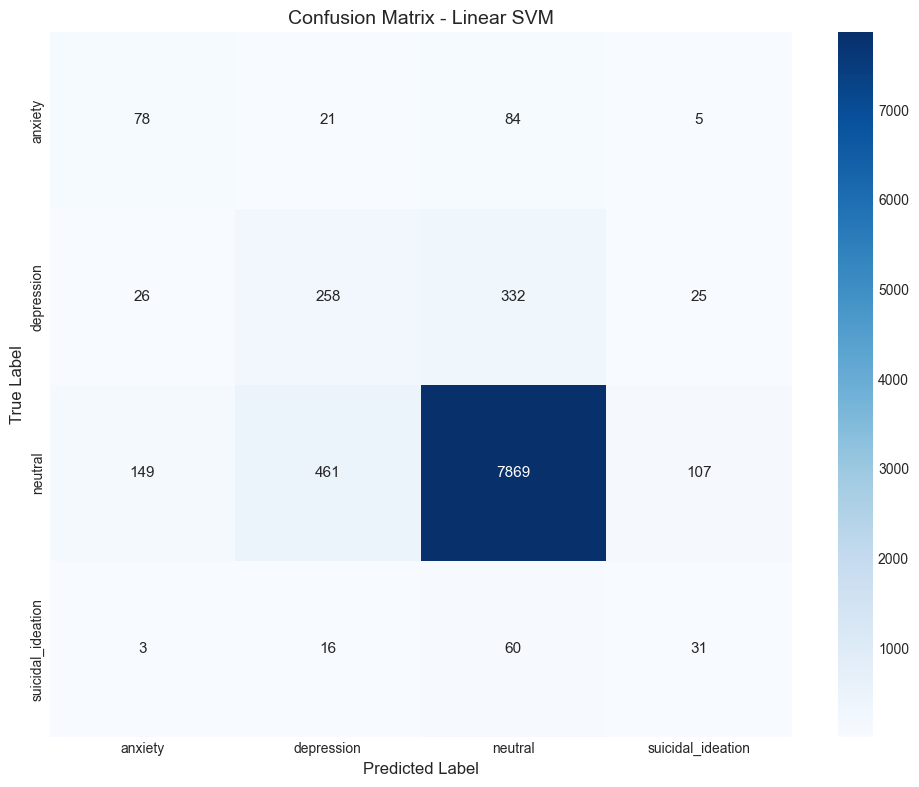


ERROR ANALYSIS
Total misclassifications: 1289 (13.53%)

anxiety:
  Misclassified: 110 / 188 (58.51%)
  Most confused with: neutral (84 times)

depression:
  Misclassified: 383 / 641 (59.75%)
  Most confused with: neutral (332 times)

neutral:
  Misclassified: 717 / 8586 (8.35%)
  Most confused with: depression (461 times)

suicidal_ideation:
  Misclassified: 79 / 110 (71.82%)
  Most confused with: neutral (60 times)


In [19]:
# Select best model for interpretation
best_model_name = comparison_df.nlargest(1, 'Test_F1_Macro')['Model'].values[0]
best_strategy = comparison_df.nlargest(1, 'Test_F1_Macro')['Strategy'].values[0]
best_model = all_results[best_strategy][best_model_name]['model']
best_predictions = all_results[best_strategy][best_model_name]['predictions']

print(f"Best model: {best_model_name} with {best_strategy} strategy")

# Feature importance for tree-based models
if hasattr(best_model, 'feature_importances_'):
    # Get feature names
    tfidf_names = feature_engineer.tfidf_vectorizer.get_feature_names_out()
    feature_names = list(tfidf_names) + available_numerical + [f'topic_{i}' for i in range(20)]
    
    # Get importances
    importances = best_model.feature_importances_
    
    # Sort and select top features
    indices = np.argsort(importances)[::-1][:30]
    
    # Plot
    plt.figure(figsize=(12, 8))
    plt.title(f'Top 30 Feature Importances - {best_model_name}')
    plt.bar(range(30), importances[indices])
    plt.xticks(range(30), [feature_names[i] for i in indices], rotation=90)
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()

# Confusion matrix analysis
cm = confusion_matrix(y_test, best_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d',
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Error analysis
print("\n" + "="*80)
print("ERROR ANALYSIS")
print("="*80)

# Misclassified samples
misclassified_mask = y_test != best_predictions
misclassified_indices = np.where(misclassified_mask)[0]

print(f"Total misclassifications: {len(misclassified_indices)} ({len(misclassified_indices)/len(y_test)*100:.2f}%)")

# Analyze misclassifications by class
for true_class in range(len(label_encoder.classes_)):
    class_mask = y_test == true_class
    class_misclassified = misclassified_mask & class_mask
    
    if class_misclassified.sum() > 0:
        print(f"\n{label_encoder.classes_[true_class]}:")
        print(f"  Misclassified: {class_misclassified.sum()} / {class_mask.sum()} ({class_misclassified.sum()/class_mask.sum()*100:.2f}%)")
        
        # Most common misclassification
        pred_for_class = best_predictions[class_mask]
        true_for_class = y_test[class_mask]
        wrong_preds = pred_for_class[pred_for_class != true_for_class]
        
        if len(wrong_preds) > 0:
            most_common_error = Counter(wrong_preds).most_common(1)[0]
            print(f"  Most confused with: {label_encoder.classes_[most_common_error[0]]} ({most_common_error[1]} times)")

## 9. Clinical Validity Assessment

In [20]:
# Clinical metrics for mental health detection
def calculate_clinical_metrics(y_true, y_pred, positive_classes=['depression', 'anxiety', 'suicidal_ideation']):
    """Calculate clinically relevant metrics"""
    
    results = {}
    
    # Convert to binary: any mental health issue vs neutral
    positive_indices = [label_encoder.transform([cls])[0] for cls in positive_classes]
    y_true_binary = np.isin(y_true, positive_indices).astype(int)
    y_pred_binary = np.isin(y_pred, positive_indices).astype(int)
    
    # Sensitivity (recall for positive class)
    results['sensitivity'] = recall_score(y_true_binary, y_pred_binary)
    
    # Specificity
    tn = np.sum((y_true_binary == 0) & (y_pred_binary == 0))
    fp = np.sum((y_true_binary == 0) & (y_pred_binary == 1))
    results['specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    # Positive Predictive Value (Precision)
    results['ppv'] = precision_score(y_true_binary, y_pred_binary)
    
    # Negative Predictive Value
    tn = np.sum((y_true_binary == 0) & (y_pred_binary == 0))
    fn = np.sum((y_true_binary == 1) & (y_pred_binary == 0))
    results['npv'] = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    # Number Needed to Screen
    tp = np.sum((y_true_binary == 1) & (y_pred_binary == 1))
    results['nns'] = len(y_pred) / tp if tp > 0 else float('inf')
    
    # Per-class sensitivity for critical conditions
    for cls in positive_classes:
        cls_idx = label_encoder.transform([cls])[0]
        cls_mask = y_true == cls_idx
        if cls_mask.sum() > 0:
            cls_recall = recall_score(
                y_true[cls_mask] == cls_idx,
                y_pred[cls_mask] == cls_idx
            )
            results[f'{cls}_sensitivity'] = cls_recall
    
    return results

# Calculate clinical metrics
clinical_metrics = calculate_clinical_metrics(y_test, best_predictions)

print("\n" + "="*80)
print("CLINICAL VALIDITY METRICS")
print("="*80)

print("\nBinary Classification (Any Mental Health Issue vs Neutral):")
print(f"  Sensitivity (Recall): {clinical_metrics['sensitivity']:.3f}")
print(f"  Specificity: {clinical_metrics['specificity']:.3f}")
print(f"  Positive Predictive Value: {clinical_metrics['ppv']:.3f}")
print(f"  Negative Predictive Value: {clinical_metrics['npv']:.3f}")
print(f"  Number Needed to Screen: {clinical_metrics['nns']:.1f}")

print("\nPer-Condition Sensitivity:")
for condition in ['depression', 'anxiety', 'suicidal_ideation']:
    if f'{condition}_sensitivity' in clinical_metrics:
        print(f"  {condition}: {clinical_metrics[f'{condition}_sensitivity']:.3f}")

# Risk stratification
print("\n" + "="*80)
print("RISK STRATIFICATION")
print("="*80)

# Define risk levels
risk_mapping = {
    'suicidal_ideation': 'CRITICAL',
    'depression': 'HIGH',
    'anxiety': 'MODERATE',
    'neutral': 'LOW'
}

# Get predicted risk levels
predicted_classes = label_encoder.inverse_transform(best_predictions)
predicted_risks = [risk_mapping[cls] for cls in predicted_classes]

# Count risk distributions
risk_counts = Counter(predicted_risks)
print("\nPredicted Risk Distribution:")
for risk in ['CRITICAL', 'HIGH', 'MODERATE', 'LOW']:
    count = risk_counts.get(risk, 0)
    percentage = count / len(predicted_risks) * 100
    print(f"  {risk:10s}: {count:5d} ({percentage:6.2f}%)")


CLINICAL VALIDITY METRICS

Binary Classification (Any Mental Health Issue vs Neutral):
  Sensitivity (Recall): 0.493
  Specificity: 0.916
  Positive Predictive Value: 0.392
  Negative Predictive Value: 0.943
  Number Needed to Screen: 20.6

Per-Condition Sensitivity:
  depression: 0.402
  anxiety: 0.415
  suicidal_ideation: 0.282

RISK STRATIFICATION

Predicted Risk Distribution:
  CRITICAL  :   168 (  1.76%)
  HIGH      :   756 (  7.94%)
  MODERATE  :   256 (  2.69%)
  LOW       :  8345 ( 87.61%)


## 11. Ethical Considerations and Limitations

### Ethical Guidelines:
1. **Privacy**: Ensure all data is anonymized and encrypted
2. **Consent**: Obtain explicit consent for mental health screening
3. **Clinical Integration**: Model should supplement, not replace, professional assessment
4. **Crisis Management**: Implement immediate referral pathways for high-risk cases
5. **Bias Monitoring**: Regular audits for demographic and linguistic biases

### Limitations:
1. **Data Quality**: Model performance depends on labeled data quality
2. **Cultural Context**: May not generalize across all Arabic dialects/cultures
3. **Temporal Validity**: Mental health expressions evolve; model needs updates
4. **False Negatives**: Critical for suicidal ideation - requires conservative thresholds
5. **Interpretability**: Deep learning models lack full explainability

### Recommendations:
1. Implement continuous monitoring and model updates
2. Establish feedback loops with mental health professionals
3. Develop region-specific model variants
4. Create comprehensive documentation for clinical users
5. Implement A/B testing framework for model improvements

In [22]:
# Final summary report
print("\n" + "="*80)
print("MENTAL HEALTH DETECTION SYSTEM - FINAL REPORT")
print("="*80)

print(f"\n📊 Dataset Statistics:")
print(f"  Total samples: {len(df):,}")
print(f"  Class imbalance ratio: {imbalance_ratio:.1f}:1")

print(f"\n🏆 Best Model Performance:")
print(f"  Model: {best_model_name} ({best_strategy})")
print(f"  F1 Score (Macro): {comparison_df.nlargest(1, 'Test_F1_Macro')['Test_F1_Macro'].values[0]:.4f}")
print(f"  F1 Score (Weighted): {comparison_df.nlargest(1, 'Test_F1_Macro')['Test_F1_Weighted'].values[0]:.4f}")

print(f"\n🏥 Clinical Metrics:")
print(f"  Sensitivity: {clinical_metrics['sensitivity']:.3f}")
print(f"  Specificity: {clinical_metrics['specificity']:.3f}")
print(f"  Suicidal Ideation Detection: {clinical_metrics.get('suicidal_ideation_sensitivity', 0):.3f}")

print(f"\n📁 Saved Artifacts:")
print(f"  - Model and pipeline: models/mental_health_model.pkl")
print(f"  - Results comparison: models/model_comparison_results.csv")

print("\n" + "="*80)
print("Research notebook completed successfully!")
print("="*80)


MENTAL HEALTH DETECTION SYSTEM - FINAL REPORT

📊 Dataset Statistics:
  Total samples: 47,625
  Class imbalance ratio: 78.2:1

🏆 Best Model Performance:
  Model: Linear SVM (Original)
  F1 Score (Macro): 0.4683
  F1 Score (Weighted): 0.8723

🏥 Clinical Metrics:
  Sensitivity: 0.493
  Specificity: 0.916
  Suicidal Ideation Detection: 0.282

📁 Saved Artifacts:
  - Model and pipeline: models/mental_health_model.pkl
  - Results comparison: models/model_comparison_results.csv

Research notebook completed successfully!
